<a href="https://colab.research.google.com/github/abhisheky2j/GAN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/Kaggle/kaggle-api.git --upgrade
import os
credentials = {"username":"depplenny","key":"c218b6c8a3963c58f9e99de7a89ec338"}
os.environ['KAGGLE_USERNAME']=credentials["username"]
os.environ['KAGGLE_KEY']=credentials["key"]

  Cloning https://github.com/Kaggle/kaggle-api.git to /tmp/pip-req-build-dq8in2fz
  Running command git clone --filter=blob:none --quiet https://github.com/Kaggle/kaggle-api.git /tmp/pip-req-build-dq8in2fz
  Resolved https://github.com/Kaggle/kaggle-api.git to commit 139fdd7ca57b3f93da8318fb68b97823a74a34df
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!kaggle datasets list -s animefacedataset

ref                               title                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------  ------------------  ----------  --------------------------  -------------  ---------  ---------------  
manishamannu/animefacedataset     animefacedataset     413825766  2020-09-01 06:56:08.460000             36          1  0.125            
vitorsimplicio2/animefacedataset  animefacedataset          4066  2025-02-28 00:16:20.527000              0          0  0.25             
splcher/animefacedataset          Anime Face Dataset   413825766  2019-10-13 16:33:20.520000          37389        424  0.9375           


In [3]:
!kaggle datasets download -d splcher/animefacedataset

Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset
License(s): DbCL-1.0


In [4]:
!unzip animefacedataset.zip -d animefacedataset

Streaming output truncated to the last 5000 lines.
  inflating: animefacedataset/images/62764_2019.jpg  
  inflating: animefacedataset/images/62765_2019.jpg  
  inflating: animefacedataset/images/62766_2019.jpg  
  inflating: animefacedataset/images/62767_2019.jpg  
  inflating: animefacedataset/images/62768_2019.jpg  
  inflating: animefacedataset/images/62769_2019.jpg  
  inflating: animefacedataset/images/6276_2003.jpg  
  inflating: animefacedataset/images/62770_2019.jpg  
  inflating: animefacedataset/images/62771_2019.jpg  
  inflating: animefacedataset/images/62772_2019.jpg  
  inflating: animefacedataset/images/62773_2019.jpg  
  inflating: animefacedataset/images/62774_2019.jpg  
  inflating: animefacedataset/images/62775_2019.jpg  
  inflating: animefacedataset/images/62776_2019.jpg  
  inflating: animefacedataset/images/62777_2019.jpg  
  inflating: animefacedataset/images/62778_2019.jpg  
  inflating: animefacedataset/images/62779_2019.jpg  
  inflating: animefacedataset/im

In [5]:
DATA_DIR = '/content/animefacedataset'

In [6]:
import os

print(os.listdir(DATA_DIR))

['images']


In [7]:
print(os.listdir(DATA_DIR+'/images')[:10])

['36665_2012.jpg', '6348_2003.jpg', '39630_2012.jpg', '51107_2015.jpg', '38243_2012.jpg', '5652_2003.jpg', '1764_2001.jpg', '42105_2013.jpg', '56255_2017.jpg', '17261_2007.jpg']


In [8]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [9]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [10]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [11]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [13]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

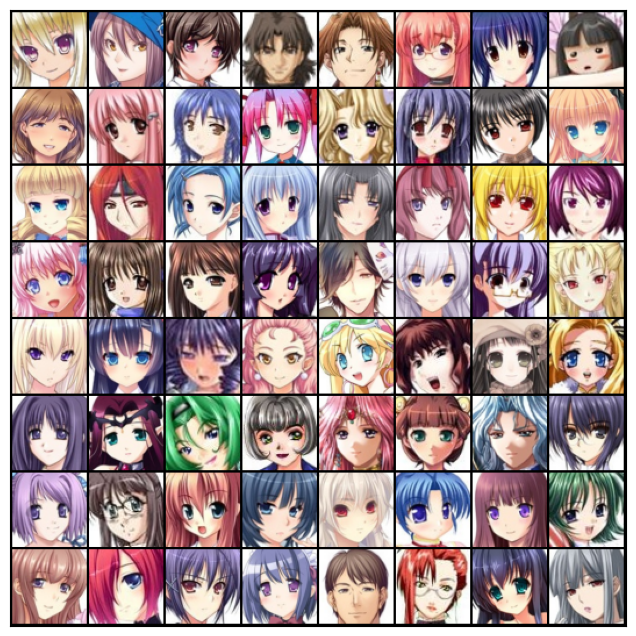

In [14]:
show_batch(train_dl)

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
device = get_default_device()
device

device(type='cuda')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)

In [18]:
import torch.nn as nn

In [19]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [20]:
discriminator = to_device(discriminator, device)

In [21]:
latent_size = 128

In [22]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


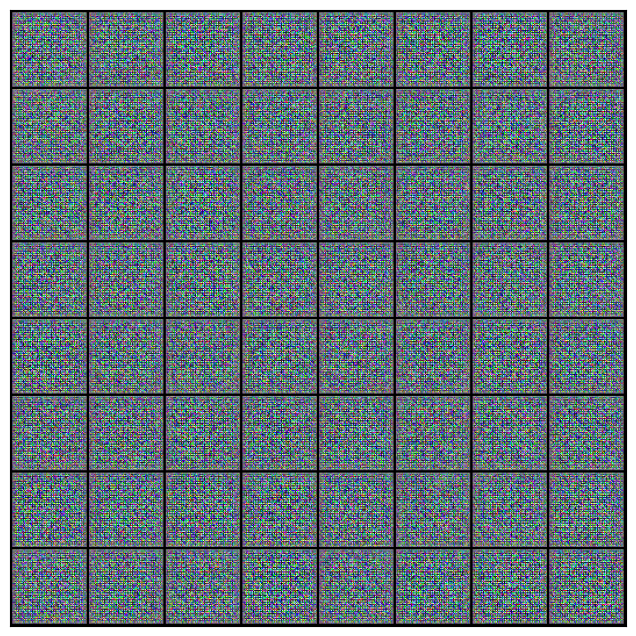

In [23]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [24]:
generator = to_device(generator, device)

In [25]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images) # 128 x 1
    # Target for discriminator is to predict 1 for all real images
    real_targets = torch.ones(real_images.size(0), 1, device=device) # 128 x 1
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    # Ideal discriminator returns 1;
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_preds = discriminator(fake_images) # 128 x 1
    # Target for discriminator is to predict 0 for all fake images
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device) # 128 x 1
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    # Ideal discriminator returns 0; Ideal generator returns 1;
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [26]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    # Target for generator is to make discriminator predict 1 for all fake images
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [27]:
from torchvision.utils import save_image

In [28]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [29]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [30]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


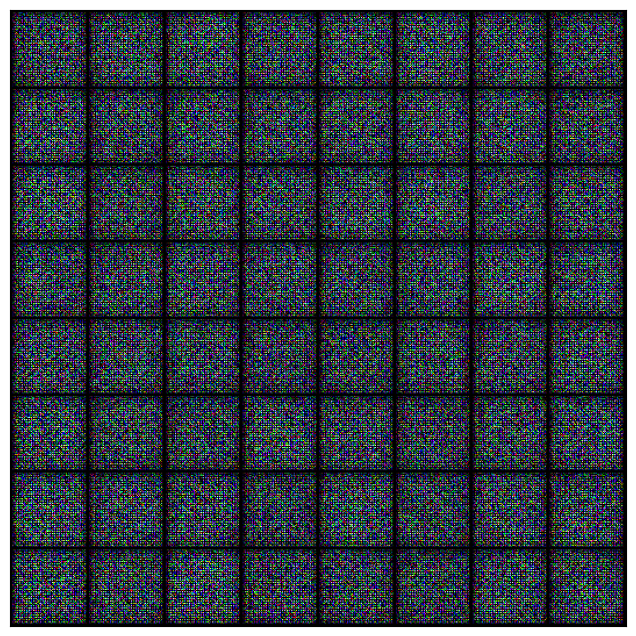

In [31]:
save_samples(0, fixed_latent)

In [32]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [33]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [34]:
lr = 0.0002
epochs = 25

In [35]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 3.4266, loss_d: 1.0133, real_score: 0.4592, fake_score: 0.0113
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 5.3222, loss_d: 0.3757, real_score: 0.7546, fake_score: 0.0399
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 6.2214, loss_d: 0.2244, real_score: 0.9424, fake_score: 0.1372
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 4.6358, loss_d: 0.1900, real_score: 0.8816, fake_score: 0.0409
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 4.6347, loss_d: 0.1948, real_score: 0.9840, fake_score: 0.1502
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 13.5671, loss_d: 0.3073, real_score: 0.7947, fake_score: 0.0001
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 7.0748, loss_d: 0.1668, real_score: 0.9410, fake_score: 0.0908
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 8.0036, loss_d: 0.2221, real_score: 0.9438, fake_score: 0.1293
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 5.7421, loss_d: 0.1283, real_score: 0.9236, fake_score: 0.0130
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 13.5111, loss_d: 0.2770, real_score: 0.9881, fake_score: 0.2054
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 7.2399, loss_d: 0.0490, real_score: 0.9763, fake_score: 0.0223
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 7.1333, loss_d: 0.0482, real_score: 0.9613, fake_score: 0.0047
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 4.2739, loss_d: 0.0755, real_score: 0.9626, fake_score: 0.0260
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 6.1482, loss_d: 0.0580, real_score: 0.9574, fake_score: 0.0022
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 6.2338, loss_d: 0.0638, real_score: 0.9706, fake_score: 0.0299
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 16.7896, loss_d: 0.0100, real_score: 0.9923, fake_score: 0.0016
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 6.3331, loss_d: 0.0436, real_score: 0.9854, fake_score: 0.0279
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 6.8853, loss_d: 0.0559, real_score: 0.9588, fake_score: 0.0088
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 8.7793, loss_d: 0.1709, real_score: 0.9991, fake_score: 0.1291
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 13.3077, loss_d: 0.2263, real_score: 0.9870, fake_score: 0.1838
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 16.6289, loss_d: 0.0749, real_score: 0.9620, fake_score: 0.0000
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 5.9715, loss_d: 0.0632, real_score: 0.9725, fake_score: 0.0191
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 12.5277, loss_d: 0.0429, real_score: 0.9837, fake_score: 0.0230
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 8.7041, loss_d: 0.0964, real_score: 0.9794, fake_score: 0.0660
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 7.5791, loss_d: 0.0869, real_score: 0.9811, fake_score: 0.0624
Saving generated-images-0025.png


In [36]:
losses_g, losses_d, real_scores, fake_scores = history

In [37]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

In [38]:
from IPython.display import Image

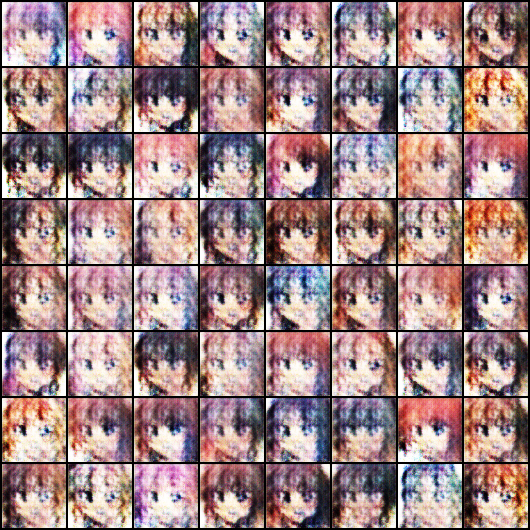

In [39]:
Image('./generated/generated-images-0001.png')

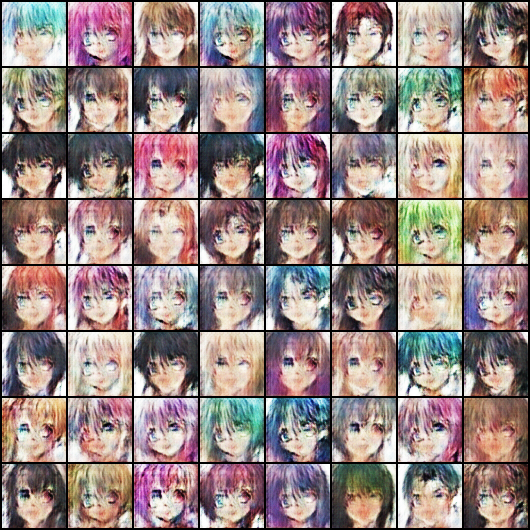

In [40]:
Image('./generated/generated-images-0005.png')

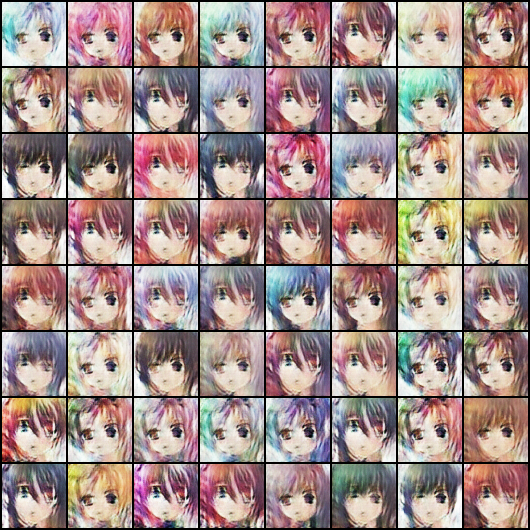

In [41]:
Image('./generated/generated-images-0010.png')

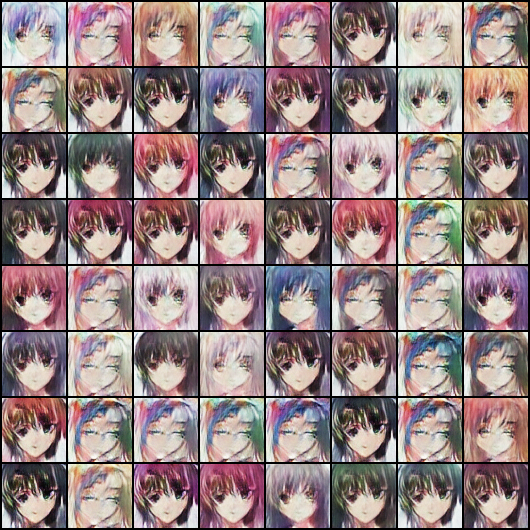

In [42]:
Image('./generated/generated-images-0020.png')

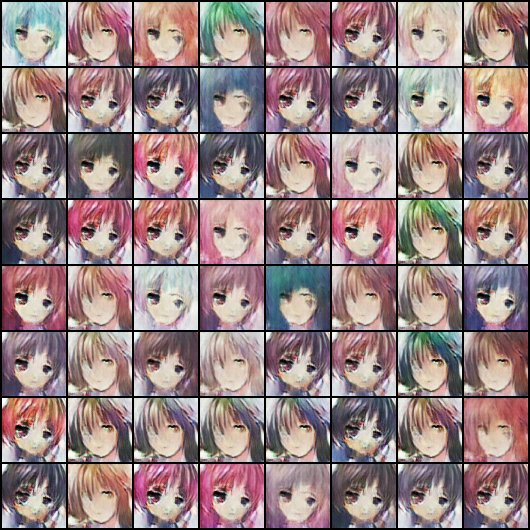

In [43]:
Image('./generated/generated-images-0025.png')

In [44]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

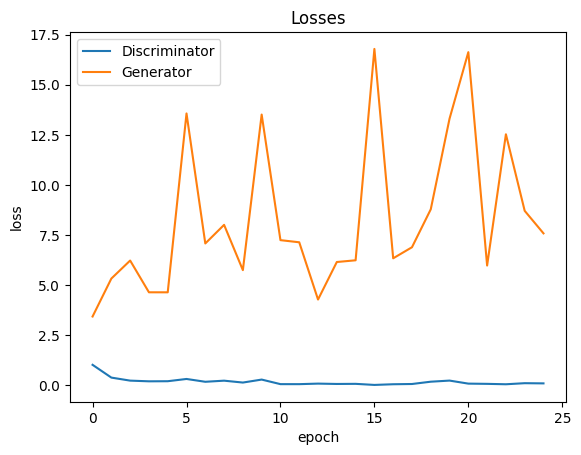

In [45]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

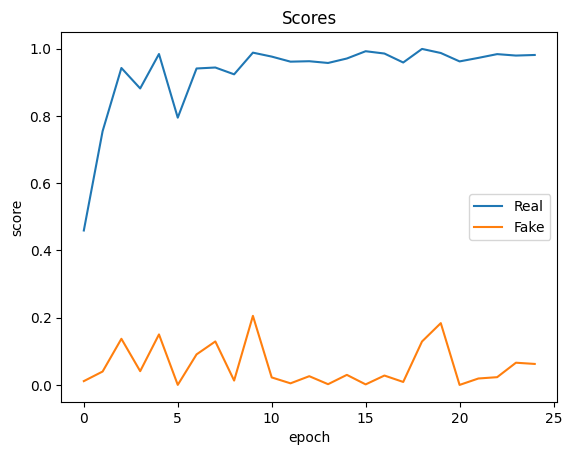

In [46]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');